In [2]:
# %% [markdown]
# # Salt Resistance Genes Comparative Analysis
# **Visualizing gene presence/absence across 4 bacterial strains**

# %%
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150

In [3]:
# %% [markdown]
# ## 1. Data Loading
# Combine all organism datasets into a single dataframe

# %%
# Define file paths and organism names
file_paths = {
    "AM1E": "am1e_genes_salt_filtrados.csv",
    "COLB": "colb_genes_salt_filtrados.csv", 
    "AM1D": "am1d_genes_salt_filtrados.csv",
    "P4D": "p4d_genes_salt_filtrados.csv"
}

# Load and combine all datasets
dfs = []
for org, path in file_paths.items():
    df = pd.read_csv(path)
    df['Organism'] = org  # Add organism label
    dfs.append(df)

combined_df = pd.concat(dfs)

# Display first 3 rows
combined_df.head(3)

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,strategy,gene_found,Organism
0,AILJCPKN_00091,861530.ALOZ01000068_gene269,0.0,1127.0,"COG2303@1|root,COG2303@2|Bacteria,1UY91@1239|F...",91061|Bacilli,E,Involved in the biosynthesis of the osmoprotec...,betA,-,...,R01025,RC00087,"ko00000,ko00001,ko00002,ko01000",-,-,-,"GMC_oxred_C,GMC_oxred_N",salt-out,betA,AM1E
1,AILJCPKN_00100,861530.ALOZ01000066_gene2174,0.0,877.0,"COG0477@1|root,COG0477@2|Bacteria,1TQIJ@1239|F...",91061|Bacilli,EGP,proline betaine transporter,proP,-,...,-,-,"ko00000,ko02000","2.A.1.6.2,2.A.1.6.4",-,-,"MFS_1,Sugar_tr",salt-out,proP,AM1E
2,AILJCPKN_00207,861530.ALOZ01000076_gene1079,0.0,937.0,"COG1292@1|root,COG1292@2|Bacteria,1TRS6@1239|F...",91061|Bacilli,M,Belongs to the BCCT transporter (TC 2.A.15) fa...,opuD_3,-,...,-,-,-,-,-,-,BCCT,salt-out,opuD_3,AM1E


In [4]:
# %% [markdown]
# ## 2. Data Cleaning
# Standardize gene names and strategies

# %%
# Clean gene names and strategies
combined_df['Gene'] = combined_df['Preferred_name'].str.upper()
combined_df['Strategy'] = combined_df['strategy']

# Check unique values
print("Unique genes:", combined_df['Gene'].nunique())
print("Strategies:", combined_df['Strategy'].unique())

Unique genes: 44
Strategies: ['salt-out' 'salt-in']


In [ ]:
# %% [markdown]
# ## 3. Create Presence/Absence Matrix
# Prepare data for heatmap visualization

# %%
# Create binary matrix (1 = present, 0 = absent)
heatmap_data = combined_df.pivot_table(
    index='Gene',
    columns='Organism',
    values='KEGG_ko',
    aggfunc=lambda x: 1 if len(x.dropna()) > 0 else 0,
    fill_value=0
)

# Sort by frequency across organisms
gene_counts = heatmap_data.sum(axis=1)
heatmap_data = heatmap_data.loc[gene_counts.sort_values(ascending=False).index]

heatmap_data.head()


Organism,AM1D,AM1E,COLB,P4D
Gene,,,,
OPUCC,1,1,1,1
OPUCB,1,1,1,1
PROS,1,1,1,1
PROC,1,1,1,1
PHOB,1,1,1,1


In [7]:
rows_to_drop = ['PROS', 'GLNK']
heatmap_data = heatmap_data.drop(rows_to_drop, errors='ignore')

heatmap_data.head()


Organism,AM1D,AM1E,COLB,P4D
Gene,,,,
OPUCC,1,1,1,1
OPUCB,1,1,1,1
PROC,1,1,1,1
PHOB,1,1,1,1
MRP,1,1,1,1


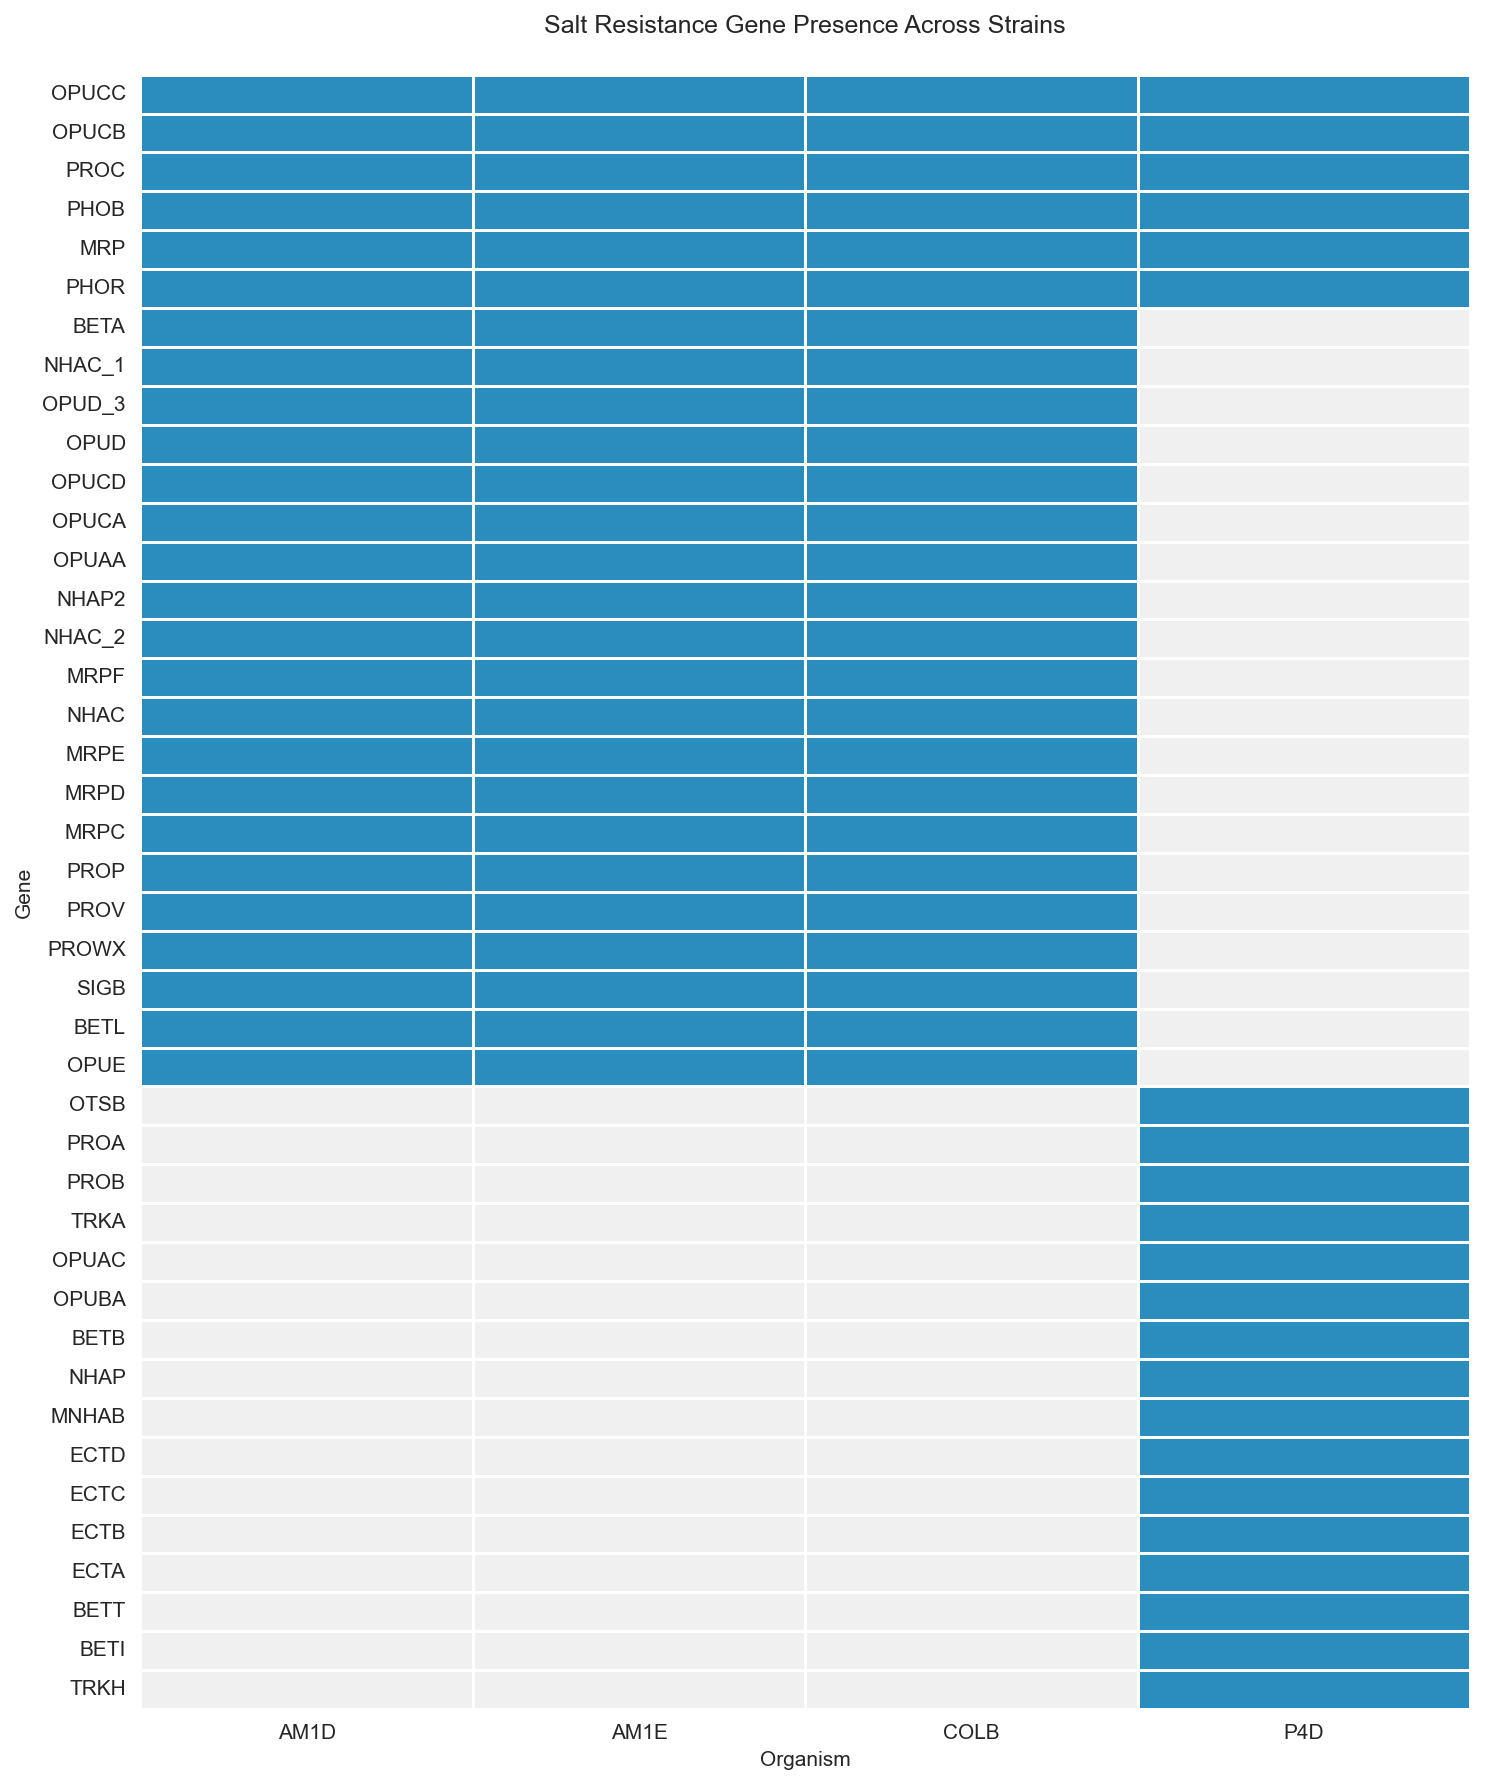

In [8]:
# %% [markdown]
# ## 4. Basic Heatmap
# Simple presence/absence visualization

# %%
plt.figure(figsize=(10, 12))
sns.heatmap(
    heatmap_data,
    cmap=['#f0f0f0', '#2b8cbe'],  # Grey/blue color scheme
    linewidths=0.5,
    linecolor='white',
    cbar=False
)

plt.title("Salt Resistance Gene Presence Across Strains", pad=20)
plt.xlabel("Organism")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

Heatmap exported to salt_resistance_heatmap.png


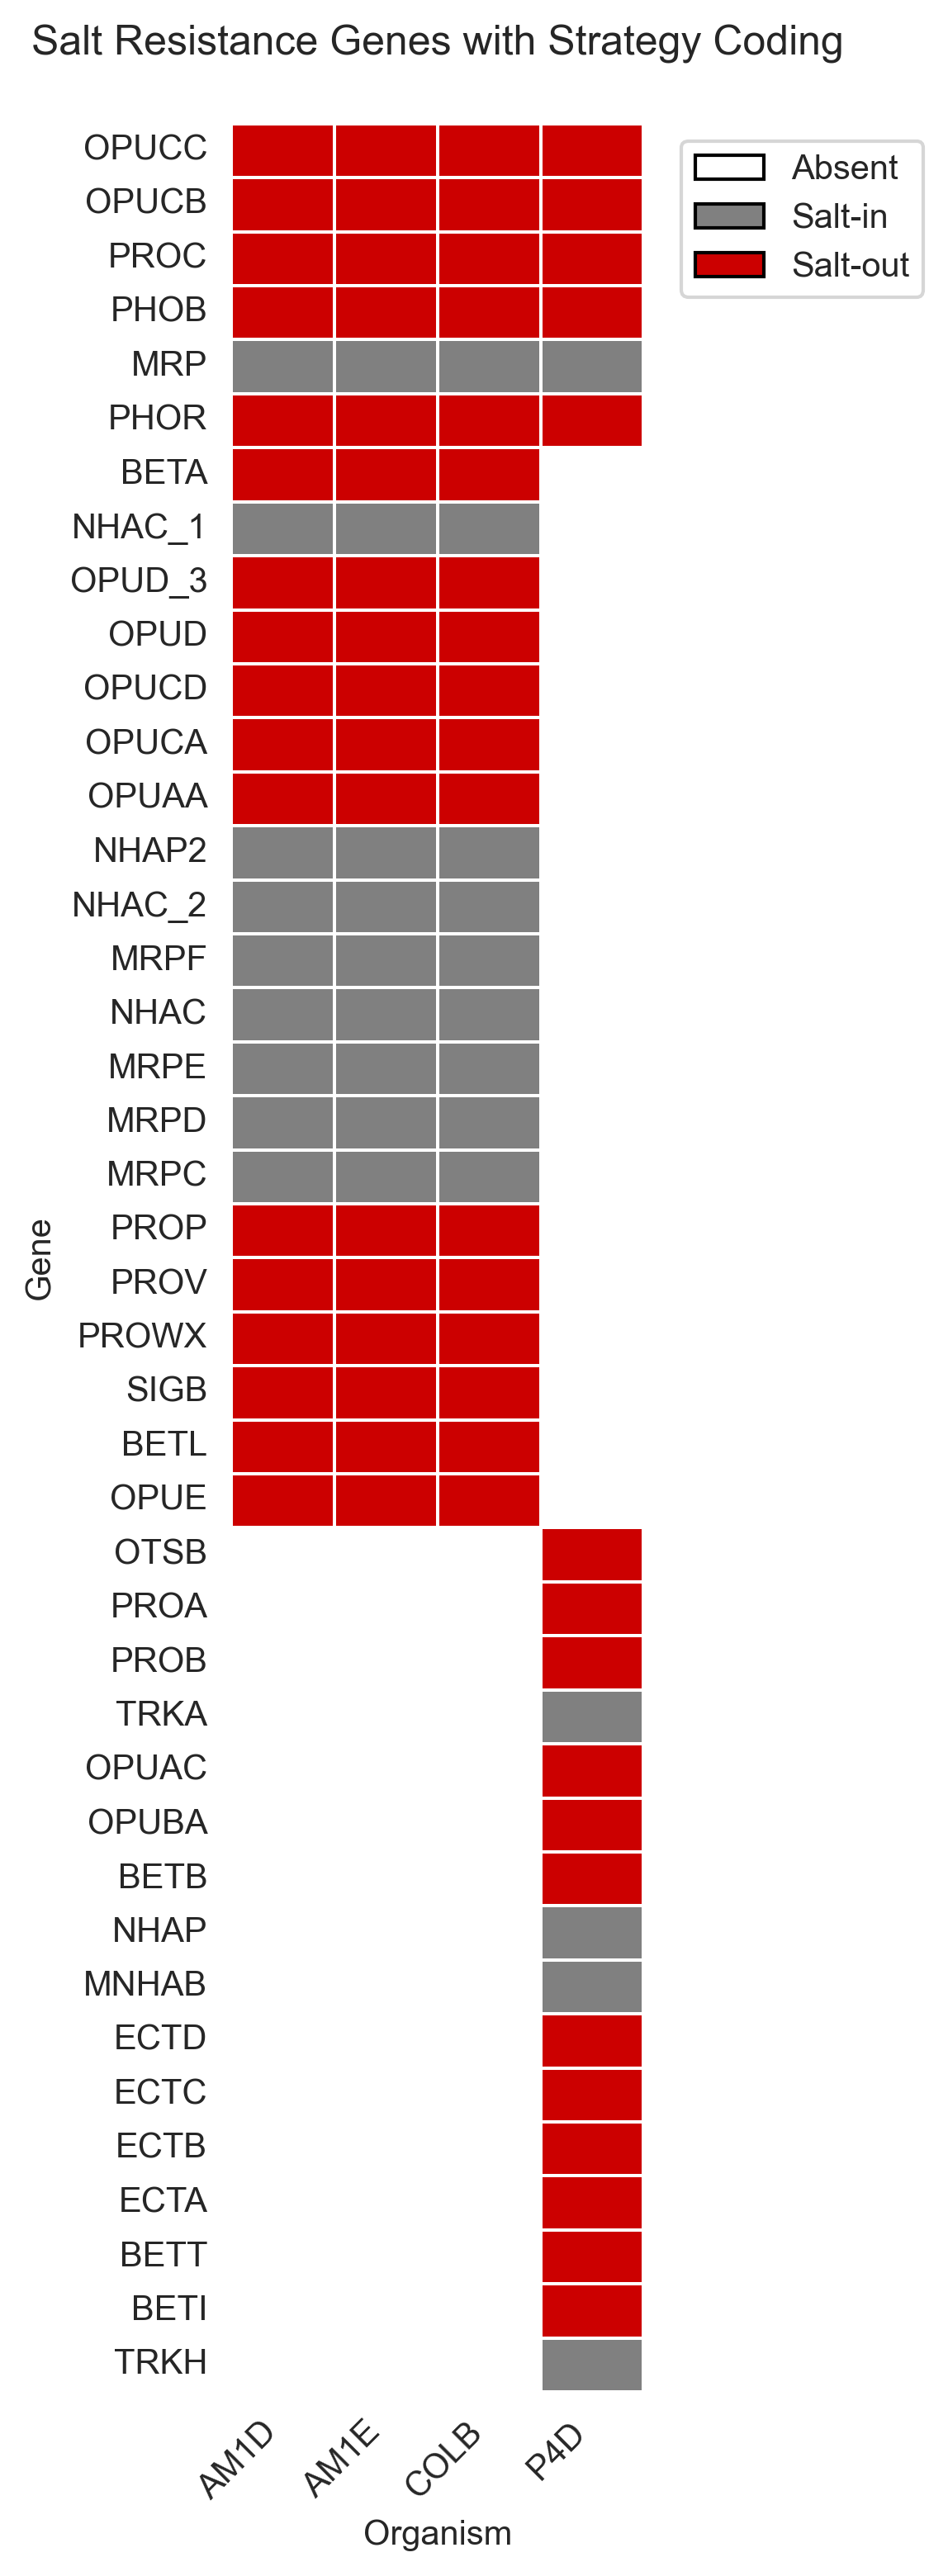

In [9]:
# %% [markdown]
# ## 5. Enhanced Heatmap with Strategies (Exportável)
# Color-coding by salt-in/salt-out mechanisms

# %%
# Create custom colormap - White/Gray/Red
cmap = ListedColormap(['#ffffff', '#808080', '#cc0000'])  # White/Gray/Dark Red

# Map strategies to values (0=absent, 1=salt-in, 2=salt-out)
strategy_map = combined_df.drop_duplicates('Gene').set_index('Gene')['Strategy']
plot_data = heatmap_data.copy()

for gene in plot_data.index:
    if gene in strategy_map:
        strategy = strategy_map[gene]
        plot_data.loc[gene] = plot_data.loc[gene] * (2 if strategy == 'salt-out' else 1)

# Calculate dimensions
n_genes = len(plot_data)
n_orgs = len(plot_data.columns)
cell_width = 0.5  # Largura das células (inches)
cell_height = cell_width / 2  # Altura reduzida pela metade

# Create figure with higher DPI for export quality
plt.figure(figsize=(n_orgs * cell_width + 2, n_genes * cell_height), dpi=300)

# Plot heatmap
ax = sns.heatmap(
    plot_data,
    cmap=cmap,
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    annot=False,
    square=False
)

# Adjust layout
ax.set_aspect('auto')

# Custom legend
legend_elements = [
    plt.Rectangle((0,0), 1, 1, fc='#ffffff', edgecolor='black', label='Absent'),
    plt.Rectangle((0,0), 1, 1, fc='#808080', edgecolor='black', label='Salt-in'),
    plt.Rectangle((0,0), 1, 1, fc='#cc0000', edgecolor='black', label='Salt-out')
]
plt.legend(handles=legend_elements, 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left',
           frameon=True)

plt.title("Salt Resistance Genes with Strategy Coding", pad=20, fontsize=12)
plt.xlabel("Organism", fontsize=10)
plt.ylabel("Gene", fontsize=10)

# Rotate organism labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Tight layout and save
plt.tight_layout()

# Export as PNG
output_path = "salt_resistance_heatmap.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')
print(f"Heatmap exported to {output_path}")

plt.show()

<Figure size 1800x2100 with 0 Axes>

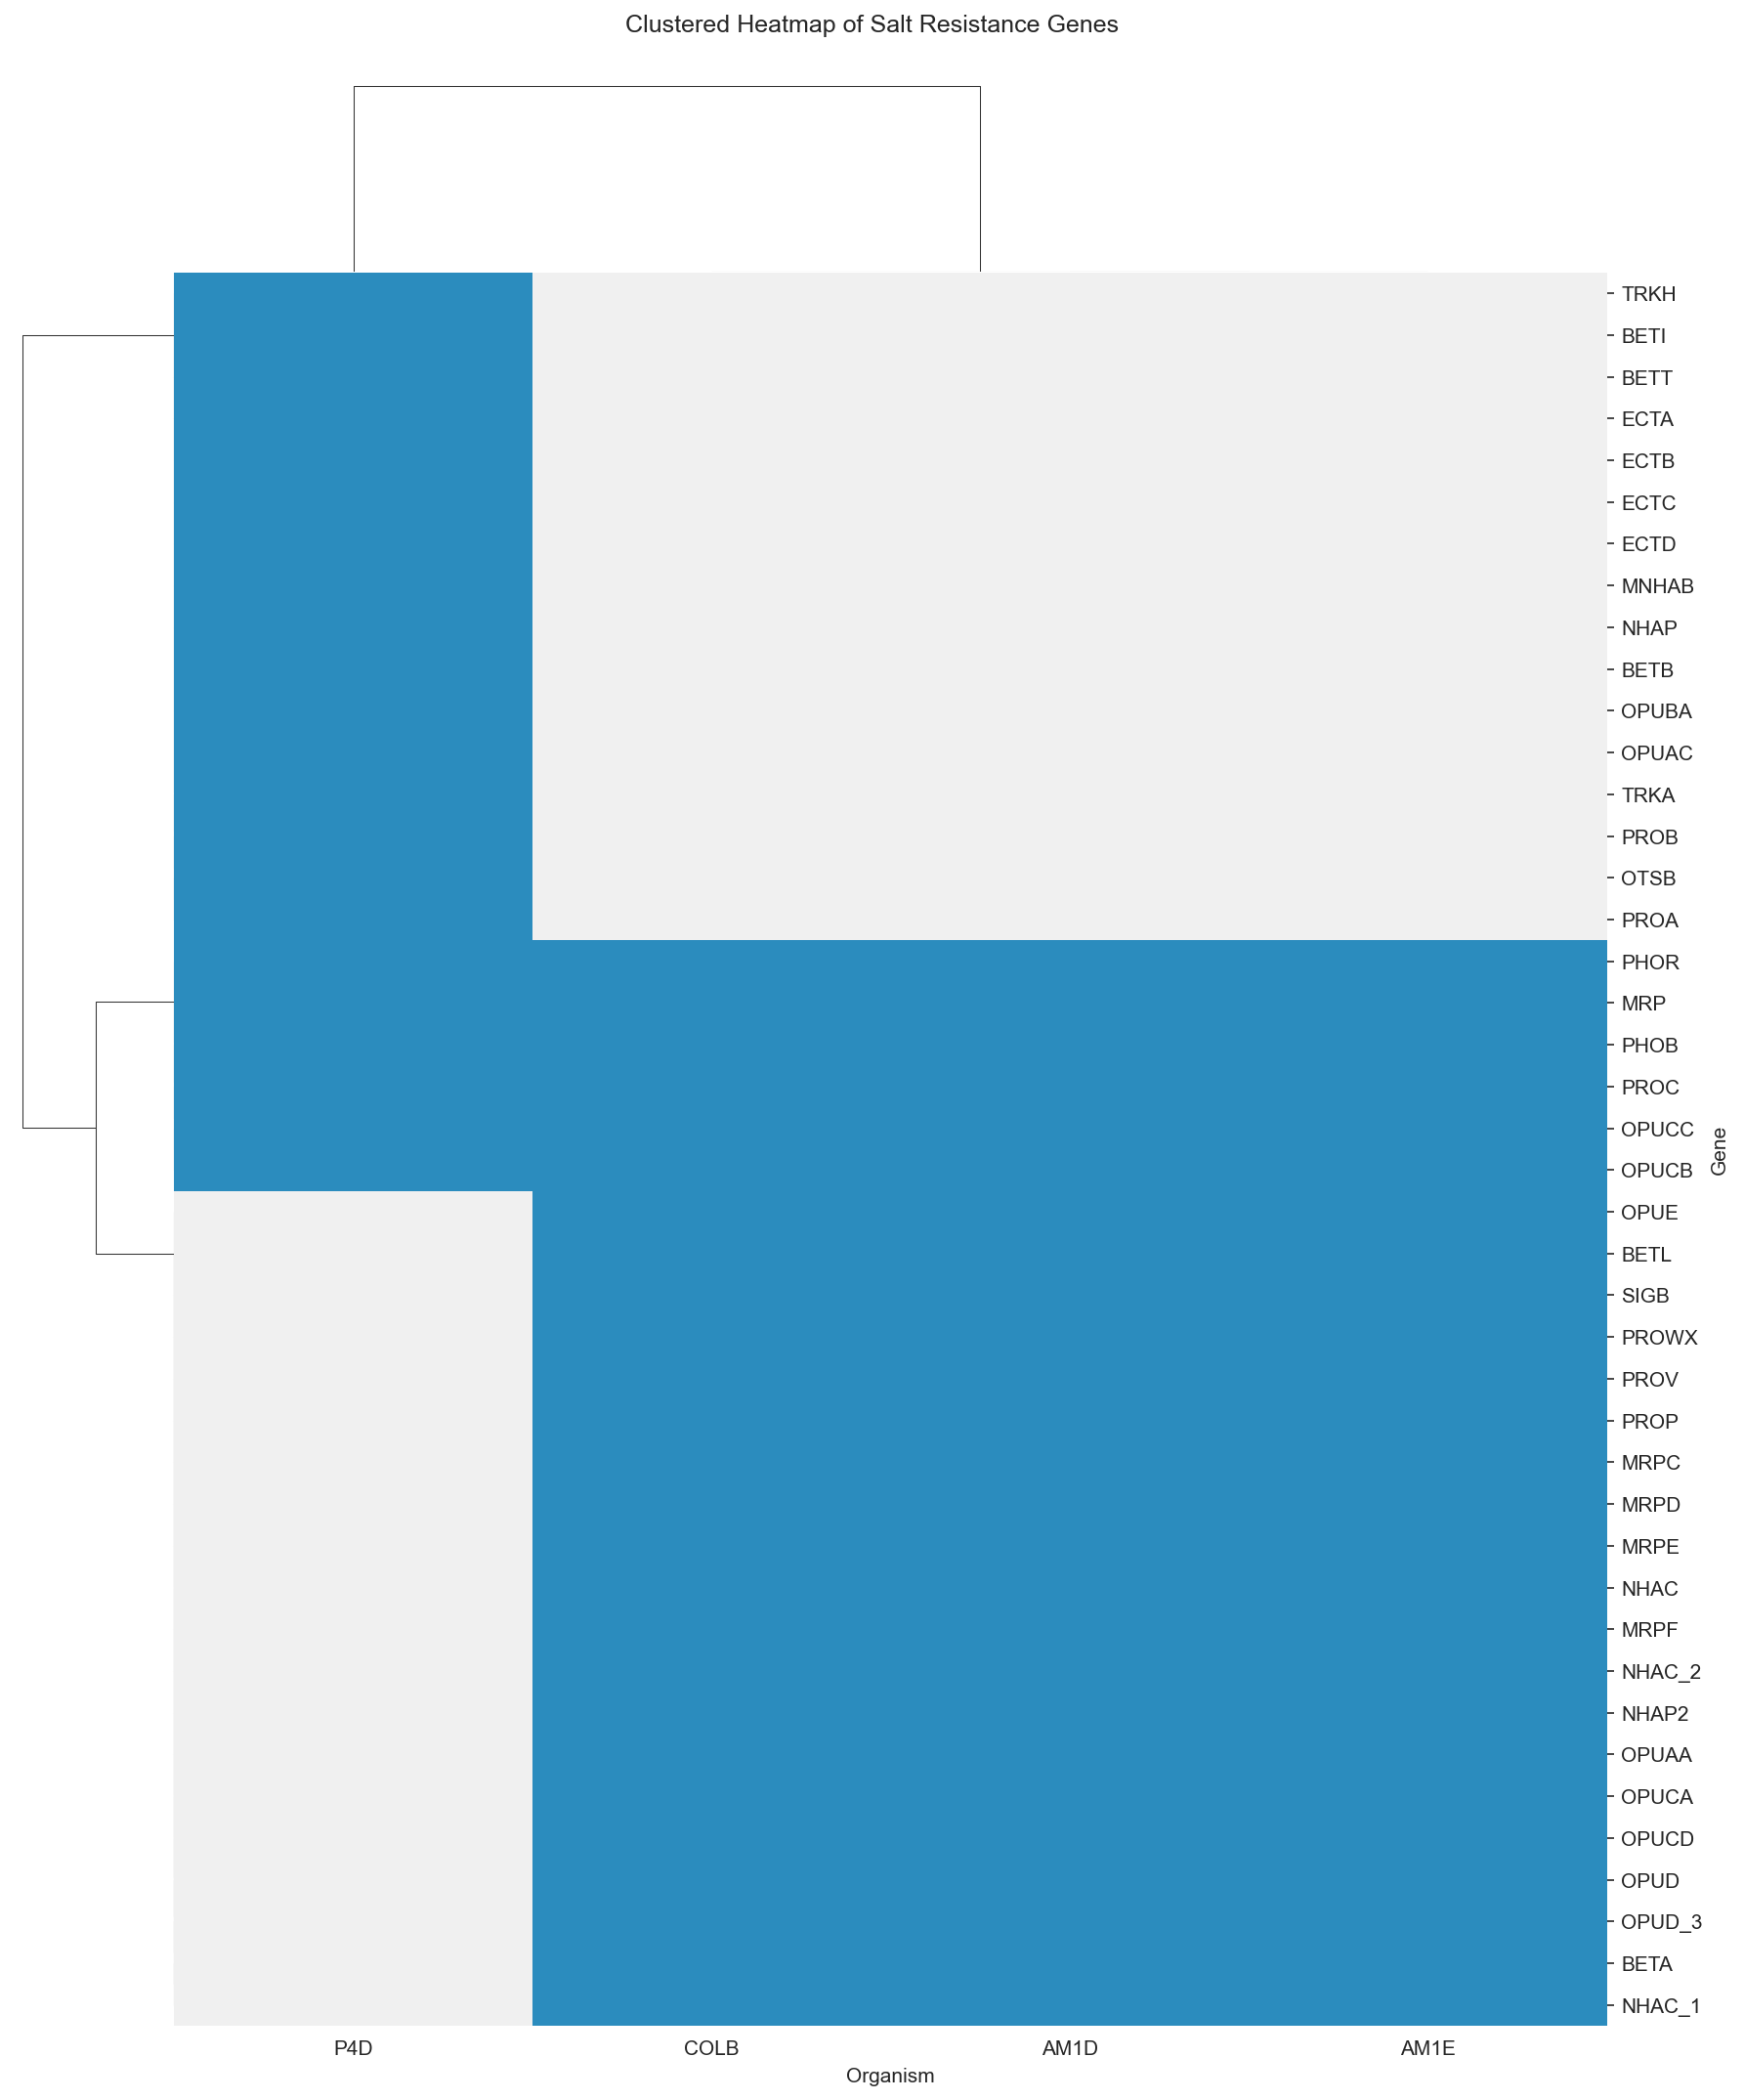

In [10]:
# %% [markdown]
# ## 6. Cluster Analysis
# Hierarchical clustering of genes and organisms

# %%
plt.figure(figsize=(12, 14))
cluster_grid = sns.clustermap(
    heatmap_data,
    cmap=['#f0f0f0', '#2b8cbe'],
    method='average',
    metric='euclidean',
    figsize=(12, 14),
    row_cluster=True,
    col_cluster=True,
    dendrogram_ratio=0.1,
    cbar_pos=None,
    yticklabels=True
)

cluster_grid.ax_heatmap.set_ylabel("Gene")
cluster_grid.ax_heatmap.set_xlabel("Organism")
cluster_grid.fig.suptitle("Clustered Heatmap of Salt Resistance Genes", y=1.02)
plt.show()

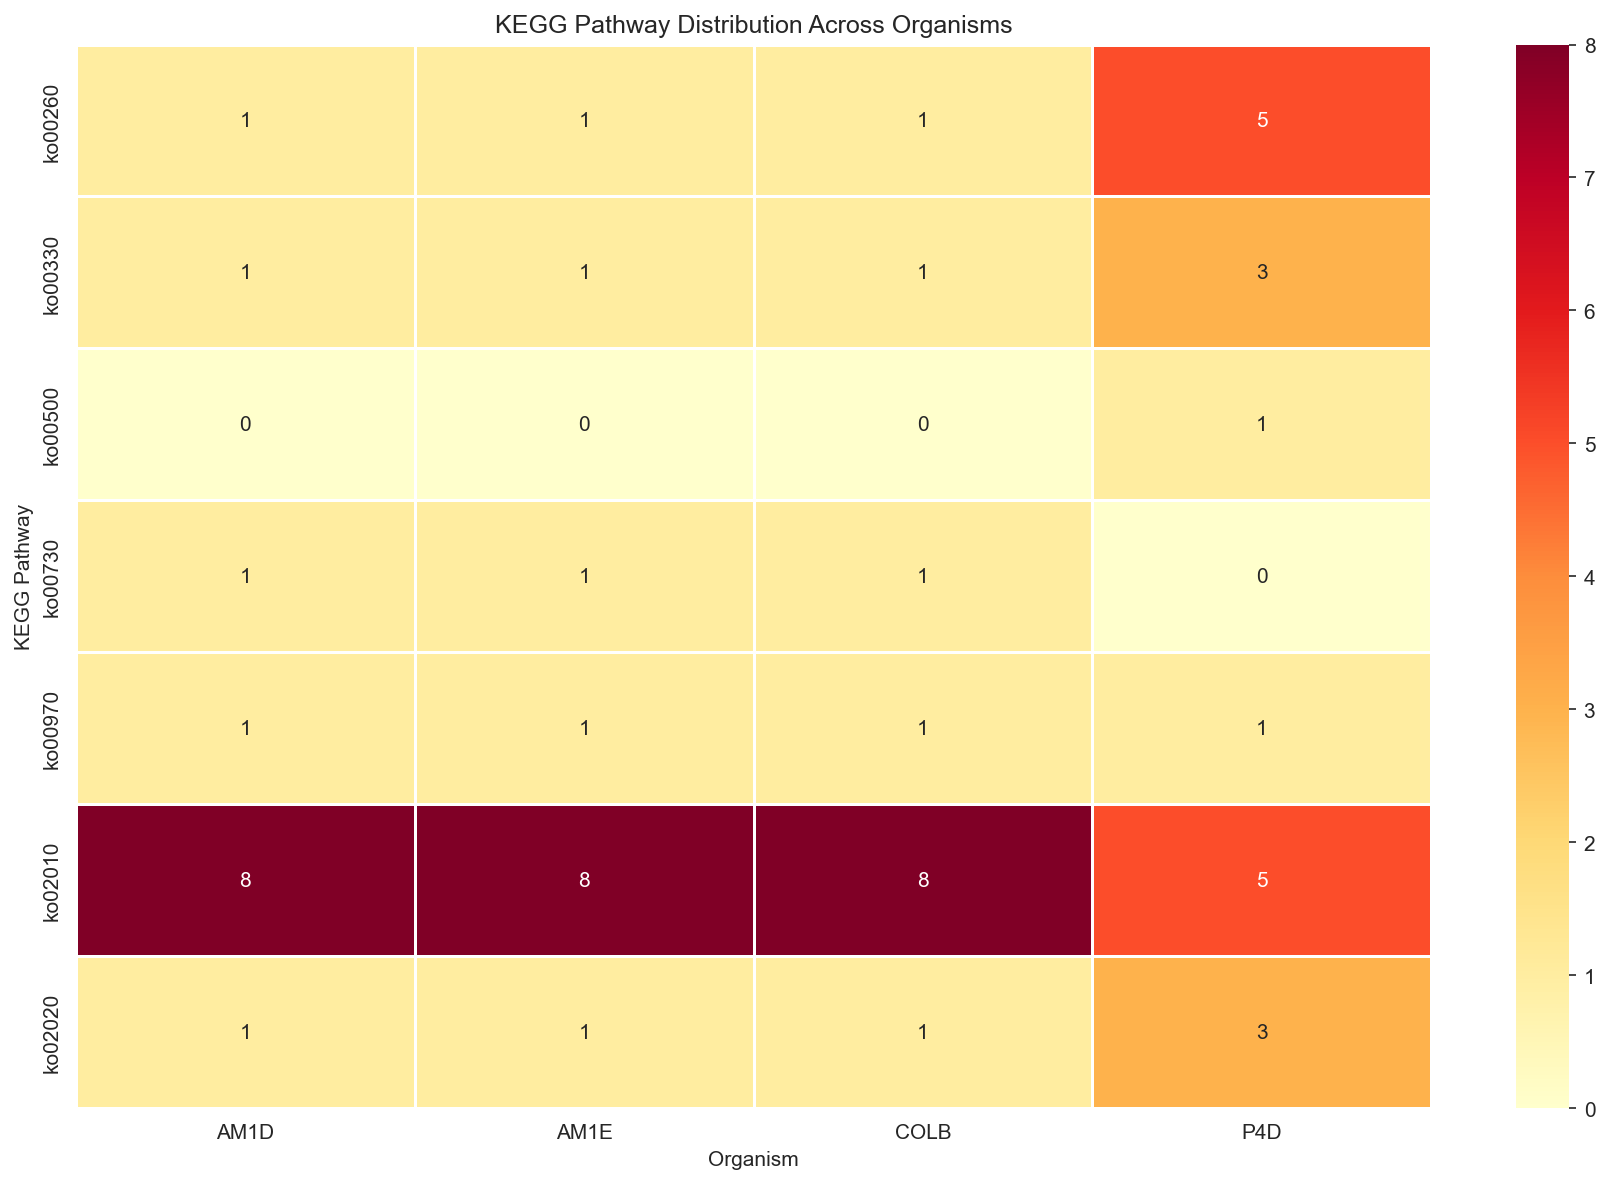

In [11]:
# %% [markdown]
# ## 7. Pathway Analysis
# Distribution of KEGG pathways across organisms

# %%
# Extract KEGG pathways
combined_df['KEGG_Pathway'] = combined_df['KEGG_Pathway'].str.extract(r'(ko\d+)')

# Count genes per pathway
pathway_counts = combined_df.groupby(['Organism', 'KEGG_Pathway']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(
    pathway_counts.T,
    cmap="YlOrRd",
    linewidths=0.5,
    annot=True,
    fmt="d"
)
plt.title("KEGG Pathway Distribution Across Organisms")
plt.xlabel("Organism")
plt.ylabel("KEGG Pathway")
plt.tight_layout()
plt.show()

In [12]:
# %% [markdown]
# ## 8. Summary Statistics
# Key metrics about the dataset

# %%
# Calculate statistics
stats = {
    "Total Genes": len(heatmap_data),
    "Genes Present in All Strains": (heatmap_data.sum(axis=1) == 4).sum(),
    "Unique to Single Strain": (heatmap_data.sum(axis=1) == 1).sum(),
    "Most Common Gene": heatmap_data.sum(axis=1).idxmax(),
    "Salt-in Genes": (strategy_map == 'salt-in').sum(),
    "Salt-out Genes": (strategy_map == 'salt-out').sum()
}

# Display as table
pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])

,Value
Total Genes,42
Genes Present in All Strains,6
Unique to Single Strain,16
Most Common Gene,OPUCC
Salt-in Genes,13
Salt-out Genes,31
